# Seconde Partie
# Attention, ce document ne concerne que la seconde partie (voir le code renvoyé par mail pour la première)
Définition des fonctions utiles ci-dessous.
Les questions sont traitées à la fin

Nous avons préféré prendre le nouveau simulateur rendre plus simple la correction, bien que le simulateur de la première partie donne les bons résultats pour FIFO.

In [1]:
import random
import numpy as np
import copy

def interarrival_time():
    return random.expovariate(2*LAMBDA)

def request_type():
    if random.random() < 0.5:
        return "storage"
    else:
        return "recovery"  

def request_level():
    return random.randint(1,L)

In [2]:
"définition du système"

import heapq #on utilise une heap pour maintenir l'échéancier ; y place un élément en O(log n), récupère le premier en O(1)

#classe Système, contient le système, mais aussi l'échéancier

class System(object):
     
    def __init__(self):
        self.schedule = [] #échéancier
        self.queues = Queues() #les différentes files d'attente des requêtes
        self.lift = Lift()
        self.requests = [] #la liste des clients
        
#classe request
        
class Request(object):
    
    def __init__(self, i):
        self.id = i #identifiant de la requête
        self.arrival = -1 #instant d'arrivée
        self.end_waiting = -1 #instant de prise en charge
        self.type = request_type() #storage ou recovery
        self.level_init = 0
        self.level_final = 0
        
        if self.type == "storage":
            self.level_final = request_level() #étage cible de la requête
            
        if self.type == "recovery":
            self.level_init = request_level() #étage initial de la requête
        
#classe ascenseur

class Lift(object):
    
    def __init__(self):
        self.level = 0 #étage cible de l'ascenseur, ou celui où il est en attente
        self.status = "idle" #idle or active
        self.request_handled = -1 #numéro de la requête actuellement servie, -1 si aucune

#classe files d'attente
        
class Queues(object):
    
    def __init__(self):
        self.level = [] #contient la liste des requêtes en attente à chaque étage
        for l in range(L+1):
            self.level.append([])

In [3]:
"définition des événements"

#classe événement

class Event(object):
    
    def __init__(self, time):
        self.time = time
        self.type = ""

#sous-classe "fin de simulation"

class Event_end(Event):
    
    def __init__(self, time):
        self.time = time
        self.type = "fin"

#sous-classe "arrivée d'une requête"

class Event_arrival(Event):
    
    def __init__(self, time):
        self.time = time
        self.type = "request_arrival"
    
    def action(self, sys):
        request = Request(len(sys.requests))
        request.arrival = self.time
        sys.requests.append(request)
        
        #print("%.2f" % self.time, ": arrivée requête", request.id, "de type", request.type, request.level_init, "--", request.level_final)
        
        if sys.lift.status == "idle": #on suppose que c'est équivalent à ce qu'aucune autre requête ne soit en attente !!!, on traite la requête immédiatement (hypothèse exacte?)
            request.end_waiting = self.time + SPEED * abs(sys.lift.level - request.level_init)
            sys.lift.status = "active"
            sys.lift.request_handled = request.id
            sys.lift.level = request.level_final
            service_duration = 2 * TAU + SPEED * abs(request.level_init - request.level_final) 
            e_end_service = Event_end_service(request.end_waiting + service_duration)
            heapq.heappush(sys.schedule, (e_end_service.time, e_end_service))
        else:
            if (request.type == "storage"):
                sys.queues.level[0].append(request)
            if (request.type == "recovery"):
                sys.queues.level[request.level_init].append(request)
         
        e_next_arrival = Event_arrival(self.time + interarrival_time())
        heapq.heappush(sys.schedule, (e_next_arrival.time, e_next_arrival)) 
             
#sous-classe "satisfaction d'une requête"
            
class Event_end_service(Event):
    
    def __init__(self, time):
        self.time = time
        self.type = "request_satisfaction"
    
    def action(self, sys):
        #print("%.2f" % self.time, ": satisfaction requête", sys.lift.request_handled, "à l'étage", sys.lift.level)
        
        warehouse_empty = True
        for j in range(len(sys.queues.level)):
            warehouse_empty = warehouse_empty and (not len(sys.queues.level[j])) #teste si l'entrepôt est vide ou non
       
        if warehouse_empty:
            sys.lift.status = "idle"
        else:
            l = next_task(sys) #c'est ici qu'on appelle NEXT-TASK
            if not sys.queues.level[l]: #si l'étage choisit par NEXT-TASK est vide
                print("NEXT-TASK a choisi un étage vide !!!")
            else:
                request = sys.queues.level[l].pop(0)
                request.end_waiting = self.time + SPEED * abs(sys.lift.level - l)
                service_duration = 2 * TAU + SPEED * abs(l - request.level_final)
                sys.lift.level = request.level_final
                sys.lift.request_handled = request.id
                e_end_service = Event_end_service(request.end_waiting + service_duration)
                heapq.heappush(sys.schedule, (e_end_service.time, e_end_service))     
  

In [13]:
"Différentes versions de NEXT-TASK : c'est ici qu'il faut les implémenter"

def next_task(sys):
    if NEXT_TASK == "FIFO":
        return fifo(sys)
    if NEXT_TASK == "GREEDY": #si par exemple vous avez codé ci-dessous une version GREEDY de NEXT_TASK
        return greedy(sys)
    if NEXT_TASK == "KGREEDY":
        K=2
        return kgreedy(sys, K)
    if NEXT_TASK == "REPLAN":
        return replan(sys)
    if NEXT_TASK == "DOUBLE_GREEDY":
        return double_greedy(sys)
    if NEXT_TASK == "2GREEDY":
        return kgreedy(sys, 2)
    if NEXT_TASK == "3GREEDY":
        return kgreedy(sys, 3)
    if NEXT_TASK == "ALTERNATE":
        return alternate(sys)
    
def fifo(sys):
    earliest_time = TOTAL_DURATION
    l = -1
    for j in range(len(sys.queues.level)):
        if len(sys.queues.level[j]) > 0:
            if sys.queues.level[j][0].arrival < earliest_time:
                earliest_time = sys.queues.level[j][0].arrival
                l = j
    return l

def greedy(sys):
    l = -1
    floors = []
    for j in range(len(sys.queues.level)):
        if len(sys.queues.level[j]) > 0:
            floors.append(j)
    k = np.argmin([abs(floor - sys.lift.level) for floor in floors])
    l = sys.queues.level[floors[k]][0].level_init
    return l

def alternate(sys):
    recovery = False
    storage = (len(sys.queues.level[0]) > 0)
    for j in range(1, len(sys.queues.level)):
        if len(sys.queues.level[j]) > 0:
            recovery = True
    if sys.lift.level == 0:
        if storage:
            return 0
        else:
            return greedy(sys)
    else:
        if recovery:
                l = -1
                floors = []
                for j in range(1, len(sys.queues.level)):
                    if len(sys.queues.level[j]) > 0:
                        floors.append(j)
                k = np.argmin([abs(floor - sys.lift.level) for floor in floors])
                l = sys.queues.level[floors[k]][0].level_init
                return l
        else:
            return 0

Pour cela, nous souhaitions implémenter une politique "K-Greedy" (cette politique a peut-être un autre nom dans la littérature, mais nous ne l'avons pas trouvé). Elle consiste à regarder l'ensemble des combinaisons de K tâches, et de trouver celle minimisant le temps à vide de l'assensseur. On peut remarquer que K-Greedy est équivalent à Replan lorsque K est supérieur ou égal au nombre maximal de tâche. 

In [14]:
import copy
def kgreedy(systeme, k, debug=False):

    def indices(n,k,L=L):
        """Pour parcourir les combinaisons, il faudrait faire k boucle for imbriquées (à priori, pas possible car k n'est pas connu en avance).
        Cette fonction permet d'écrire en base k le chiffre n (tant que n < k^(L+1)). il suffit de parcourir n dans 0:k^(L+1)-1 pour obtenir les combinaisons de k indices"""
                
        list_indices = [0 for _ in range(k)]
        occurence = [0 for i in range(L+1)]
        r=n
        for i in range(k):
            list_indices[-1-i] = r // ((L+1)**(k-1-i))
            r = r - list_indices[-1-i]*((L+1)**(k-1-i))
            occurence[list_indices[-1-i]] += 1
        return list_indices, occurence

    def combi_possible(occurence,queue_size):

        for i in range(L+1):
            if queue_size[i] < occurence[i]:
                return False
        return True
    
    
    sys = copy.deepcopy(systeme)
    k = min(k,sum([len(sys.queues.level[i]) for i in range(L+1)]))
    best_path = None
    best_time = (L+1) * k
    queue_size =[len(sys.queues.level[i]) for i in range(L+1)]
    #print("queues : ",queue_size)
    for n in range((L+1)**(k)): 
        list_indices, occurence = indices(n,k)
        #print(occurence)
        if combi_possible(occurence,queue_size):
            #print("occurence : ",occurence)
            queue = [sys.queues.level[i].copy() for i in range(L+1)]
            time = 0
            lift_level = sys.lift.level
            for i in range(len(list_indices)):
                indice = list_indices[i]
                #print([len(queue[i]) for i in range(L+1)])
                #print(indice)
                task = queue[indice].pop(0)
                time += abs(lift_level - task.level_init)
                lift_level = task.level_final
            if time < best_time:
                #print("New best time : ",time," for ", list_indices)
                best_time = time
                best_path = list_indices.copy()
                if best_time == 0:
                    if debug:
                        return best_path[0], best_path, best_time
                    return best_path[0]
        
    if debug:
        return best_path[0], best_path, best_time
    return best_path[0]

def replan(sys):
    return kgreedy(sys, sum([len(sys.queues.level[i]) for i in range(L+1)]))

In [15]:
L=7

def test_kgreedy():
    sys = System()
    random.seed(9)
    for i in range(10):
        request=Request(i)
        sys.queues.level[request.level_init].append(request)
        print(request)
    print(kgreedy(sys,5, True))  

#test_kgreedy()

In [30]:
"Lance la simulation, nombre de réplications donné par NBR_RUNS"

from statistics import mean

LAMBDA = 0.07 #intensité des deux processus d'arrivées : nombre moyen d'arrivées par unité de temps
L = 7 #nombre d'étages
TAU = 1 #temps de charge et décharge
SPEED = 1 #nombre d'étages parcourus par seconde
NBR_RUNS = 20 # nombre de réplications
CONFIDENCE_LEVEL = 95 #pourcentage donnant le niveau de confiance des résultats
TOTAL_DURATION = 2000000 #durée totale simulée
TRANSIENT_DURATION = 1000000 #temps estimé pour arriver en régime transient
NEXT_TASK = "ALTERNATE" #pour choisir la version de NEXT-TASK

waiting_times_run = [] #contient le temps moyen d'attente pour chaque run

for i in range(NBR_RUNS):
    random.seed(i) #permet de la reproductibilité
    sys = System()
    # e_fin = Event_end(TOTAL_DURATION)
    # heapq.heappush(sys.schedule, (e_fin.time, e_fin))
    e = Event_arrival(0)
    heapq.heappush(sys.schedule, (e.time, e))
    
    while e.time < TOTAL_DURATION:
        (time, e) = heapq.heappop(sys.schedule)
        e.action(sys)
    
    waiting_times_requests = [] #temps d'attente par client pour la réplication i courante
   
    for j in range(len(sys.requests)):
        #on ne garde que les requêtes qui sont arrivées en régime permanent et qui ont quitté l'entrepôt'
        if sys.requests[j].end_waiting != -1 and sys.requests[j].arrival >= TRANSIENT_DURATION:
            waiting_times_requests.append(sys.requests[j].end_waiting - sys.requests[j].arrival)

    
    waiting_times_run.append(mean(waiting_times_requests))
    waiting_times_requests.clear()

In [31]:
"Fait l'analyse"

from scipy.stats import t, sem

waiting_mean = mean(waiting_times_run)
waiting_sample_standard_error = sem(waiting_times_run)
confidence_interval = t.interval(CONFIDENCE_LEVEL / 100, NBR_RUNS - 1, waiting_mean, waiting_sample_standard_error)

print("Temps moyen d'attente : %.4f" % waiting_mean)
print("Intervalle de confiance à %d%%: " % CONFIDENCE_LEVEL, end="") ; print("(%.4f, %.4f)" % confidence_interval) 

Temps moyen d'attente : 55.9369
Intervalle de confiance à 95%: (55.2816, 56.5921)


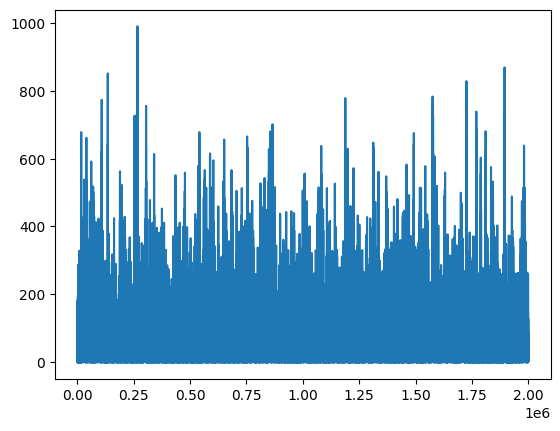

Moyenne empirique : 56.7553


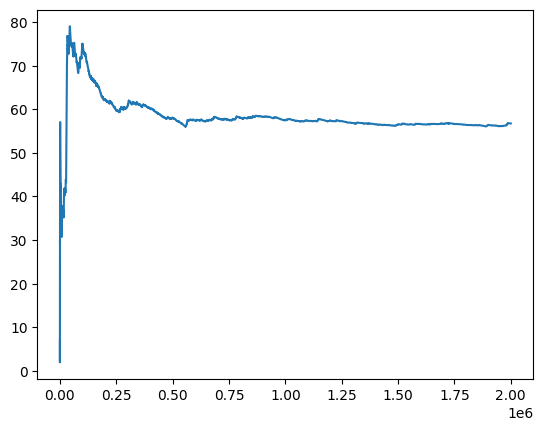

In [32]:
"Tracés sur la dernière réplication"

import matplotlib.pyplot as plt

average_waiting_times = []
total = 0

arrival_times_requests = []
waiting_times_requests = []

for j in range(len(sys.requests)):
    if sys.requests[j].end_waiting != -1:
        arrival_times_requests.append(sys.requests[j].arrival) 
        waiting_times_requests.append(sys.requests[j].end_waiting - sys.requests[j].arrival)

plt.plot(arrival_times_requests,waiting_times_requests)
plt.show()

for j in range(len(waiting_times_requests)):
    total += waiting_times_requests[j]
    average_waiting_times.append(total / (j+1))

print("Moyenne empirique : %.4f" % average_waiting_times[len(waiting_times_requests)-1])

plt.plot(arrival_times_requests,average_waiting_times)
plt.show()

Afin 

## Question 5:

L'algorithme greedy consiste à toujours aller traiter la requête la plus proche, quel que soit son temps d'arrivée. Les trajets sont donc à chaque fois les plus petits possibles, et le robot ne passe donc devant une requête sans la traiter (lorsqu'il en a la possibilité). En ce sens là, l'algorithme peut offrir de bonnes performances, mais dans certains cas de figures, et cela sans engorgement, il peut totalement ignorer des requêtes pour un temps très long (ce que ne fait pas le FIFO qui finit toujours par traiter les requêtes).

**Function** greedy(système)
  - l ← -1
  - a <- étage actuel de l'ascenseur
  - floors ← []
  - **For** j parcourt étages
    - **If** étage j non vide
      - floors.append(j)
    - **End If**
  - **End For**
  - k ← argmin({|floor - a| for floor in floors})
  - l ← première requête de l'étage k
  - **Return** l
**End Function**


## Question 6

Pour notre algorythme, nous voulons étendre l'idée de l'algorythme greedy à plusieurs tâches : au lieu de simplement minimiser le temps de trajet à vide jusqu'à la première tâche, on trouve la combinaison de k tâches à faire minimisant le temps à vide. On remarque que si on choisit pour k le nombre de tâche du système, on obtient l'algorythme replan.

Voiçi le pseudo-code de cet algorythme :

**Function** kgreedy(système, k)
  - $k ← min(k, $ nombre de tâches)
  - $t_{opt} ← (L+1)^k$
  - $chemin_{opt} ← []$
  - **For** $i_1, .., i_k$ parcourant les combinaisons d'étages
    - **If** $i_1, .., i_k$ est une combinaison de requête possible ($i_x$ indique l'étage de la $x^{ème}$ tâche)
      - $t ←$ temps à vide de l'assenseur jusqu'à la dernière tâche
      - **If** $t < $t_{opt}$
        - $t_{opt} ← t$
        - $chemin_{opt} ← [i_1, .., i_k]$
      - **End If**
    - **End If**
  - **End For**
  - **Return** $chemin_{opt}[0]$
  
**End Function**

Son implémentation concrète est trouvable avec le code des autres algorythmes. Une cellule est également disponible pour tester la fonction sur une instance quelconque.

ATTENTION : Le code est particulièrement long à executer. Pour replan, l'algorythme prend plusieurs secondes à calculer des instances à 8 tâches. K-greedy est plus rapide, et nous testerons pour K=2 et K=3, avec des durées réduites.

In [106]:
"Lance la simulation, nombre de réplications donné par NBR_RUNS"

"""ATTENTION : La simulation prend 2h à s'effectuer. Voiçi les résultats
LAMBDA = 0.01 algorithm = 2GREEDY
Temps moyen d'attente : 3.6083
Intervalle de confiance à 95%: (3.4996, 3.7171)
LAMBDA = 0.01 algorithm = 3GREEDY
Temps moyen d'attente : 3.6088
Intervalle de confiance à 95%: (3.4994, 3.7182)
LAMBDA = 0.03 algorithm = 2GREEDY
Temps moyen d'attente : 6.6520
Intervalle de confiance à 95%: (6.3889, 6.9151)
LAMBDA = 0.03 algorithm = 3GREEDY
Temps moyen d'attente : 6.7266
Intervalle de confiance à 95%: (6.4632, 6.9900)
LAMBDA = 0.05 algorithm = 2GREEDY
Temps moyen d'attente : 14.8210
Intervalle de confiance à 95%: (13.9931, 15.6489)
LAMBDA = 0.05 algorithm = 3GREEDY
Temps moyen d'attente : 15.0352
Intervalle de confiance à 95%: (14.2138, 15.8566)
LAMBDA = 0.07 algorithm = 2GREEDY
Temps moyen d'attente : 63.3496
Intervalle de confiance à 95%: (53.3730, 73.3262)
LAMBDA = 0.07 algorithm = 3GREEDY
Temps moyen d'attente : 49.6552
Intervalle de confiance à 95%: (45.1193, 54.1911)
LAMBDA = 0.09 algorithm = 2GREEDY
Temps moyen d'attente : 1379.9034
Intervalle de confiance à 95%: (1267.9533, 1491.8535)
LAMBDA = 0.09 algorithm = 3GREEDY
Temps moyen d'attente : 1285.9935
Intervalle de confiance à 95%: (1145.9853, 1426.0016)
"""
if False:
    for LAMBDA in [0.01, 0.03, 0.05, 0.07, 0.09]:
        for NEXT_TASK in {"2GREEDY","3GREEDY"}:
            print("LAMBDA = %.2f" % LAMBDA, 'algorithm =', NEXT_TASK)  
            L = 7 #nombre d'étages
            TAU = 1 #temps de charge et décharge
            SPEED = 1 #nombre d'étages parcourus par seconde
            NBR_RUNS = 20 # nombre de réplications
            CONFIDENCE_LEVEL = 95 #pourcentage donnant le niveau de confiance des résultats
            TOTAL_DURATION = 20000 #durée totale simulée
            TRANSIENT_DURATION = 10000 #temps estimé pour arriver en régime transient

            waiting_times_run = [] #contient le temps moyen d'attente pour chaque run

            for i in range(NBR_RUNS):
                random.seed(i) #permet de la reproductibilité
                sys = System()
                # e_fin = Event_end(TOTAL_DURATION)
                # heapq.heappush(sys.schedule, (e_fin.time, e_fin))
                e = Event_arrival(0)
                heapq.heappush(sys.schedule, (e.time, e))
                
                while e.time < TOTAL_DURATION:
                    (time, e) = heapq.heappop(sys.schedule)
                    e.action(sys)
                
                waiting_times_requests = [] #temps d'attente par client pour la réplication i courante
            
                for j in range(len(sys.requests)):
                    #on ne garde que les requêtes qui sont arrivées en régime permanent et qui ont quitté l'entrepôt'
                    if sys.requests[j].end_waiting != -1 and sys.requests[j].arrival >= TRANSIENT_DURATION:
                        waiting_times_requests.append(sys.requests[j].end_waiting - sys.requests[j].arrival)

                
                waiting_times_run.append(mean(waiting_times_requests))
                waiting_times_requests.clear()

            "Fait l'analyse"

            from scipy.stats import t, sem

            waiting_mean = mean(waiting_times_run)
            waiting_sample_standard_error = sem(waiting_times_run)
            confidence_interval = t.interval(CONFIDENCE_LEVEL / 100, NBR_RUNS - 1, waiting_mean, waiting_sample_standard_error)

            print("Temps moyen d'attente : %.4f" % waiting_mean)
            print("Intervalle de confiance à %d%%: " % CONFIDENCE_LEVEL, end="") ; print("(%.4f, %.4f)" % confidence_interval) 

LAMBDA = 0.01 algorithm = 2GREEDY
Temps moyen d'attente : 3.6083
Intervalle de confiance à 95%: (3.4996, 3.7171)
LAMBDA = 0.01 algorithm = 3GREEDY
Temps moyen d'attente : 3.6088
Intervalle de confiance à 95%: (3.4994, 3.7182)
LAMBDA = 0.03 algorithm = 2GREEDY
Temps moyen d'attente : 6.6520
Intervalle de confiance à 95%: (6.3889, 6.9151)
LAMBDA = 0.03 algorithm = 3GREEDY
Temps moyen d'attente : 6.7266
Intervalle de confiance à 95%: (6.4632, 6.9900)
LAMBDA = 0.05 algorithm = 2GREEDY
Temps moyen d'attente : 14.8210
Intervalle de confiance à 95%: (13.9931, 15.6489)
LAMBDA = 0.05 algorithm = 3GREEDY
Temps moyen d'attente : 15.0352
Intervalle de confiance à 95%: (14.2138, 15.8566)
LAMBDA = 0.07 algorithm = 2GREEDY
Temps moyen d'attente : 63.3496
Intervalle de confiance à 95%: (53.3730, 73.3262)
LAMBDA = 0.07 algorithm = 3GREEDY
Temps moyen d'attente : 49.6552
Intervalle de confiance à 95%: (45.1193, 54.1911)
LAMBDA = 0.09 algorithm = 2GREEDY
Temps moyen d'attente : 1379.9034
Intervalle de co

On remarque malheureusement des résultats moins bon que greedy (contrairement à ce à quoi on se serait attendu, et malgré de nombreuses vérifications sur l'algorythme kgreedy (voir code et cellule de test)). Replan prend trop de temps à s'executer pour ces simulations. Concernant les simulations, 2-greedy semble meilleurs sur les basses fréquences d'arrivées, et 3-greedy est meilleur sur les hautes fréquences.

Note : Nous n'avons pas vraiment d'explication sur pourquoi kgreedy est moins performant que greedy en particulier pour les valeurs basse de k. Notre seul explication serait qu'en regardant les k éléments suivants (en particuliers), l'algorithme va privilégier des gains de temps "trop loin dans le futur" (alors que, l'algorythme étant online, l'instance aura probablement changé une fois une tâche fini). Cela pousse l'algorithme à perdre du temps potentiellement sur la première tâche (pour en récupérer sur les tâches suivantes), alors que l'instance aura déjà changé une fois la tâche terminée (et donc le gain de temps futur peut devenir obsolète).

Nous avons également un algorythme "alternate" qui consistait à alterner dès que possible entre des tâches de stockage et des tâches de récupération (étant données que leurs fréquences sont égales). Malheureusement les résultats restaient pire que pour Greedy.

## Question 7

In [107]:
"Lance la simulation, nombre de réplications donné par NBR_RUNS"

for LAMBDA in [0.01, 0.03, 0.05, 0.07, 0.09]:
    for NEXT_TASK in {"FIFO", "GREEDY"}:
        print("LAMBDA = %.2f" % LAMBDA, 'algorithm =', NEXT_TASK)  
        L = 7 #nombre d'étages
        TAU = 1 #temps de charge et décharge
        SPEED = 1 #nombre d'étages parcourus par seconde
        NBR_RUNS = 20 # nombre de réplications
        CONFIDENCE_LEVEL = 95 #pourcentage donnant le niveau de confiance des résultats
        TOTAL_DURATION = 2000000 #durée totale simulée
        TRANSIENT_DURATION = 1000000 #temps estimé pour arriver en régime transient

        waiting_times_run = [] #contient le temps moyen d'attente pour chaque run

        for i in range(NBR_RUNS):
            random.seed(i) #permet de la reproductibilité
            sys = System()
            # e_fin = Event_end(TOTAL_DURATION)
            # heapq.heappush(sys.schedule, (e_fin.time, e_fin))
            e = Event_arrival(0)
            heapq.heappush(sys.schedule, (e.time, e))
            
            while e.time < TOTAL_DURATION:
                (time, e) = heapq.heappop(sys.schedule)
                e.action(sys)
            
            waiting_times_requests = [] #temps d'attente par client pour la réplication i courante
        
            for j in range(len(sys.requests)):
                #on ne garde que les requêtes qui sont arrivées en régime permanent et qui ont quitté l'entrepôt'
                if sys.requests[j].end_waiting != -1 and sys.requests[j].arrival >= TRANSIENT_DURATION:
                    waiting_times_requests.append(sys.requests[j].end_waiting - sys.requests[j].arrival)

            
            waiting_times_run.append(mean(waiting_times_requests))
            waiting_times_requests.clear()

        "Fait l'analyse"

        from scipy.stats import t, sem

        waiting_mean = mean(waiting_times_run)
        waiting_sample_standard_error = sem(waiting_times_run)
        confidence_interval = t.interval(CONFIDENCE_LEVEL / 100, NBR_RUNS - 1, waiting_mean, waiting_sample_standard_error)

        print("Temps moyen d'attente : %.4f" % waiting_mean)
        print("Intervalle de confiance à %d%%: " % CONFIDENCE_LEVEL, end="") ; print("(%.4f, %.4f)" % confidence_interval) 

LAMBDA = 0.01 algorithm = GREEDY
Temps moyen d'attente : 3.5403
Intervalle de confiance à 95%: (3.5261, 3.5546)
LAMBDA = 0.01 algorithm = FIFO
Temps moyen d'attente : 3.5946
Intervalle de confiance à 95%: (3.5784, 3.6108)
LAMBDA = 0.03 algorithm = GREEDY
Temps moyen d'attente : 6.6690
Intervalle de confiance à 95%: (6.6444, 6.6935)
LAMBDA = 0.03 algorithm = FIFO
Temps moyen d'attente : 7.8396
Intervalle de confiance à 95%: (7.7997, 7.8794)
LAMBDA = 0.05 algorithm = GREEDY
Temps moyen d'attente : 13.9482
Intervalle de confiance à 95%: (13.8935, 14.0030)
LAMBDA = 0.05 algorithm = FIFO
Temps moyen d'attente : 32.8266
Intervalle de confiance à 95%: (32.4141, 33.2391)
LAMBDA = 0.07 algorithm = GREEDY
Temps moyen d'attente : 47.4589
Intervalle de confiance à 95%: (47.0007, 47.9170)
LAMBDA = 0.07 algorithm = FIFO
Temps moyen d'attente : 265610.5750
Intervalle de confiance à 95%: (264168.8088, 267052.3413)
LAMBDA = 0.09 algorithm = GREEDY
Temps moyen d'attente : 113910.9319
Intervalle de confi

Pour les valeurs de $\lambda$ = 0,01, les scores sont quasi les mêmes, la fréquence d'arrivée est trop faible pour que le choix de la stratégie ait une grande influence. Il n'y a pas d'engorgements. En revanche, à partir de $\lambda$=0,03 on observe que la différence se creuse dans les résultats. A $\lambda$ = 0,07 , le score pour FIFO explose (265 610) tandis que celui de GREEDY reste raisonnable (47,4589). A $\lambda$=0,08 , les deux scores sont élevés, mais on remarque que FIFO diverge beaucoup plus vite. On peut conclure de  cette série de simulations, au vu des résultats présentés que GREEDY est beaucoup plus efficace que FIFO qui fait exploser les scores quand le nombre d'arrivées est trop important. En effet, la volonté de traiter les premières requêtes à être arrivées va faire que chaque requête va être traitée, mais il va ignorer d'autres requêtes qur son chemin, ce qui va faire qu'il va faire beaucoup de trajets à vide. En effet, s'il redescend à 0 pour envoyer une requête et qu'une requête de stockage s'y trouve, il se peut qu'il l'ignore pour aller chercher une requête à un étage positif qui serait arrivée avant. Il fera ce trajet à vide. De son côté, le GREEDY traitera cette requête.